In [1]:
import tensorflow as tf
import re
import pandas as pd
import numpy as np

## 데이터 불러오기

In [2]:
#!curl -L -O https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv

In [3]:
df_origin = pd.read_csv('ChatbotData.csv')

In [4]:
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


In [5]:
df_origin.head(5)

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [6]:
def preprocess_sentence(sentence):
    sentence = re.sub(r'([?.!,])', r' \1', sentence)
    sentence = re.sub(r'[" "]+', ' ', sentence)
    sentence = sentence.strip()
    return sentence

In [7]:
preprocess_sentence(preprocess_sentence(df_origin.loc[130,'Q']))

'게임도 이제 재미없어'

## Subword Text Encoder

In [8]:
# question, answer로 분할
questions = df_origin['Q'].tolist()
answers = df_origin['A'].tolist()
len(questions), len(answers)

(11823, 11823)

In [9]:
import tensorflow_datasets as tfds
# subword 기준으로 tokenizing
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13
)

In [10]:
print(tokenizer.vocab_size)

8170


In [11]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여
START_TOKEN, DELIMITER_TOKEN, END_TOKEN  = [tokenizer.vocab_size], [tokenizer.vocab_size + 1], [tokenizer.vocab_size + 2]
START_TOKEN, DELIMITER_TOKEN, END_TOKEN

([8170], [8171], [8172])

In [12]:
VOCAB_SIZE = tokenizer.vocab_size + 3
print(VOCAB_SIZE)

8173


In [13]:
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5759, 607, 2490, 4160]
정수 인코딩 후의 21번째 답변 샘플: [2353, 7510, 5, 6273, 94, 7960]


In [14]:
# MAX_LENGTH
MAX_LENGTH = 40

### 데이터셋 만들기

**참고**
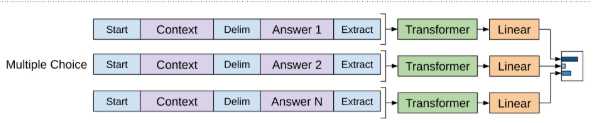

- START + Question + DELIMITER + Answer + END 순으로 데이터 생성

In [15]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_sentence = []

    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence = START_TOKEN + tokenizer.encode(sentence1) + DELIMITER_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        if len(sentence) <= MAX_LENGTH:
            tokenized_sentence.append(sentence)

    # 최대 길이로 모든 데이터셋을 패딩
    tokenized_sentence = tf.keras.preprocessing.sequence.pad_sequences(tokenized_sentence, maxlen=MAX_LENGTH, padding='post')
    
    return tokenized_sentence

In [16]:
tokenized_sentence = tokenize_and_filter(questions, answers)
    
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(tokenized_sentence)))

단어장의 크기 : 8173
필터링 후의 질문 샘플 개수: 11822


In [17]:
print(tokenized_sentence[10])

[8170 5772  480  191 2978   42 3811 8171 6340   45 1624  330 7960 8172
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [18]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'dec_inputs': tokenized_sentence[:, :-1],
    },
    {
        'outputs': tokenized_sentence[:, 1:],
    }
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [19]:
print(tokenized_sentence[:, :-1][0])
print(tokenized_sentence[:, 1:][0])

[8170 7909 4200 3054 7947 8171 3837   71 7888 7960 8172    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
[7909 4200 3054 7947 8171 3837   71 7888 7960 8172    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]


## GPT 모델 구성하기

**GPT Model**
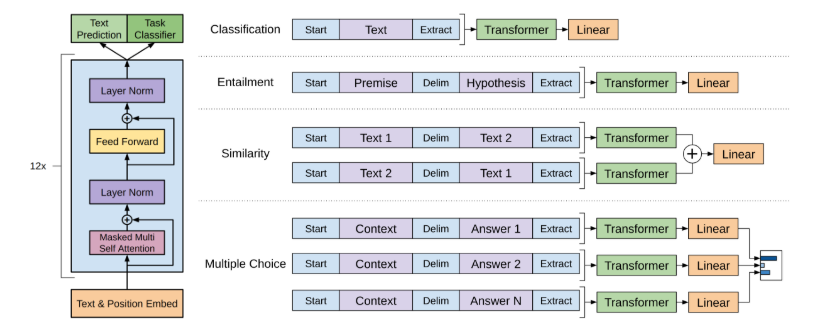

**Transformer model과의 차이점**

- Encoder, Encoder_layer, Encoder-Decoder Attention 등 삭제
    - GPT 모델에는 Encoder가 존재하지 않음

In [20]:
class PositionalEncoding(tf.keras.layers.Layer):
    
    # 최대 문장 길이와 임베딩 벡터의 차원을 변수로 받음
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
        
    # 각도 생성
    # positional encoding의 vector 수식 참조
    # angles = 1 / 10000^(2i/d_model)
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [21]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

In [22]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

In [23]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    # tf.newaxis : 새로운 차원 추가
    return mask[:, tf.newaxis, tf.newaxis, :]

In [24]:
# tf.linalg.band_part(tensor, -1, 0)
# [[1,0,0],
# [1,1,0]
# [1,1,1]]
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

### Decode Layer

**Transformer Model과의 차이점**
- enc_outputs, padding_mask 삭제
    - Encoder-Decoder Multi head Attention 삭제에 따른 연관 변수들 삭제
- attenion2 삭제
    - Encoder-Decoder Multihead Attention 구현 코드이므로 GPT에서는 불필요하므로 삭제
- Dense(attention1)
    - Dense에 입력으로 attention1(Masked Attention)으로 변경
- outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention1)
    - 이후 LayerNormalization에서 FFNN 출력과 Masked Attention의 출력을 LayerNorm의 입력으로 변경

In [25]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    #enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    #padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

    # LayerNormalization 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # encoder-decoder multi head attention Pass
    '''
    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })


    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)
    '''
    
    # FFNN : 첫 번째 멀티 헤드 어텐션의 출력을 받는 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention1)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    
    # Masked Multi head Attention의 출력과 output을 Normalization
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention1)

    return tf.keras.Model(
        inputs=[inputs, look_ahead_mask], outputs=outputs, name=name
    )

### Decoder

**Transformer Model과의 차이점**
- enc_outputs, padding_mask 삭제
    - Encoder-Decoder Multi head Attention 삭제에 따른 연관 변수들 삭제
- decoder_layer(...)(inputs=[...])
    - inputs 수정
    - enc_outputs, padding_mask 삭제
- tf.keras.Model(inputs=[inputs, look_ahead_mask],...)
    - inputs 수정
    - enc_outputs, padding_mask 삭제

In [26]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    # GPT model에는 encoder output이 필요 없음
    #enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    #padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # inputs 수정
    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, look_ahead_mask])

    # inputs 수정
    return tf.keras.Model(
        inputs=[inputs, look_ahead_mask],
        outputs=outputs, name=name
    )

### GPT method

**Transformer Model과의 차이점**
- Encoder inputs, enc_padding_mask, dec_padding_mask 등 삭제
    - dec_padding_mask의 경우, encoder-decoder attention에 사용되므로 삭제
- Model(inputs=) 변경
    - encoder inputs가 삭제됨에 따라 변경

In [27]:
def GPT(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="gpt"):
    
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, look_ahead_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=dec_inputs, outputs=outputs, name=name)

## 모델 생성 및 훈련

In [28]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = GPT(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

model.summary()

Model: "gpt"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           dec_inputs[0][0]                 
__________________________________________________________________________________________________
decoder (Functional)            (None, None, 256)    3146496     dec_inputs[0][0]                 
                                                                 look_ahead_mask[0][0]            
__________________________________________________________________________________________________
outputs (Dense)                 (None, None, 8173)   2100461     decoder[0][0]                  

In [29]:
# Decoder 내부에 존재하는 레이어들 출력
model.layers[2].summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    2092288     inputs[0][0]                     
__________________________________________________________________________________________________
tf.math.multiply (TFOpLambda)   (None, None, 256)    0           embedding[0][0]                  
__________________________________________________________________________________________________
positional_encoding (Positional (None, None, 256)    0           tf.math.multiply[0][0]           
____________________________________________________________________________________________

In [30]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [31]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [32]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [33]:
epochs = 20
history = model.fit(
    dataset, epochs=epochs, verbose=1
)

Epoch 1/20
185/185 [==============================] - 9s 35ms/step - loss: 2.9346 - accuracy: 0.0275
Epoch 2/20
185/185 [==============================] - 7s 35ms/step - loss: 2.4805 - accuracy: 0.0727
Epoch 3/20
185/185 [==============================] - 6s 35ms/step - loss: 2.1707 - accuracy: 0.0765
Epoch 4/20
185/185 [==============================] - 7s 35ms/step - loss: 2.0187 - accuracy: 0.0822
Epoch 5/20
185/185 [==============================] - 6s 35ms/step - loss: 1.9132 - accuracy: 0.0883
Epoch 6/20
185/185 [==============================] - 6s 35ms/step - loss: 1.8170 - accuracy: 0.0941
Epoch 7/20
185/185 [==============================] - 6s 34ms/step - loss: 1.7188 - accuracy: 0.1000
Epoch 8/20
185/185 [==============================] - 6s 34ms/step - loss: 1.6168 - accuracy: 0.1076
Epoch 9/20
185/185 [==============================] - 6s 34ms/step - loss: 1.5090 - accuracy: 0.1163
Epoch 10/20
185/185 [==============================] - 6s 35ms/step - loss: 1.3971 - accura

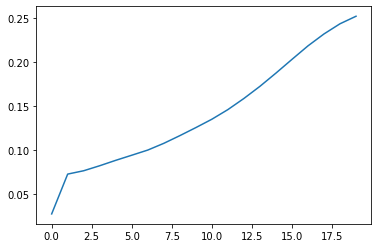

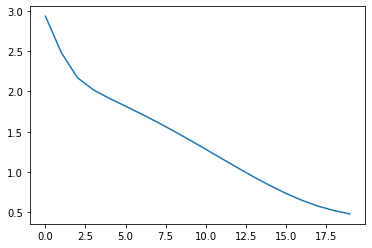

In [34]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.show()

plt.plot(history.history['loss'])
plt.show()

## 테스트

In [35]:
s = '슬프네'
sentence = preprocess_sentence(s)
sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + DELIMITER_TOKEN, axis=0)

print(sentence)
#sentence = tf.keras.preprocessing.sequence.pad_sequences(sentence, maxlen=MAX_LENGTH, padding='post')

predictions = model.predict(sentence)
predictions = np.argmax(predictions, axis=-1).reshape(-1)
print(predictions)

tf.Tensor([[8170 3453   36 8171]], shape=(1, 4), dtype=int32)
[   7   14 7977   19]


In [36]:
tokenizer.decode([i for i in predictions if i < tokenizer.vocab_size])

'좋아하는 고 ?좋은 '

In [37]:
s = '오늘 하루 어때?'
sentence = preprocess_sentence(s)
sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + DELIMITER_TOKEN, axis=0)

print(sentence)
#sentence = tf.keras.preprocessing.sequence.pad_sequences(sentence, maxlen=MAX_LENGTH, padding='post')

predictions = model.predict(sentence)
predictions = np.argmax(predictions, axis=-1).reshape(-1)
print(predictions)
print(tokenizer.decode([i for i in predictions if i < tokenizer.vocab_size]))

tf.Tensor([[8170   73  685  373 7946 7977 8171]], shape=(1, 7), dtype=int32)
[   7 2771 2834 7977  299 8171   97]
좋아하는 하루도 종일 ?좋을까저도 


In [38]:
s = '오늘 좀 심심하네'
sentence = preprocess_sentence(s)
sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + DELIMITER_TOKEN, axis=0)

print(sentence)
#sentence = tf.keras.preprocessing.sequence.pad_sequences(sentence, maxlen=MAX_LENGTH, padding='post')

predictions = model.predict(sentence)
predictions = np.argmax(predictions, axis=-1).reshape(-1)
print(predictions)
print(tokenizer.decode([i for i in predictions if i < tokenizer.vocab_size]))

tf.Tensor([[8170   73   22 5149  350 8171]], shape=(1, 6), dtype=int32)
[   7 2771 7169 1277 8171 1604]
좋아하는 하루도 바쁘네한데 친구들과 
